In [ ]:
%%capture

import numpy as np
import pandas as pd
import os
from os.path import join
from zipfile import ZipFile

import random as rd

import spacy
import tensorflow as tf
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.models as models
from torchvision import transforms

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F

from torchtext.vocab import FastText
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from math import ceil
from matplotlib import pyplot as plt
from PIL import Image
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset_path = '/content/drive/MyDrive/VK_internship'

In [ ]:
def zip2jpeg(zip, png_name, dest):
  norm = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ])
  with ZipFile(zip, 'r') as zip_file:
    if (png_name) in zip_file.namelist():
      zip_file.extract(png_name, path=dest)
    else:
      print(f'PNG file {png_name} not found in {zip}')
    png_file = Image.open(os.path.join(dest, png_name)).convert('RGB')
    png_file.save(os.path.join(dest, png_name[:-4] + '.jpeg'), 'JPEG', quality=60)
    png_file = Image.open(os.path.join(dest, png_name[:-4] + '.jpeg')).convert('RGB')
    png_file = preprocess(png_file)
    png_file.save(os.path.join(dest, png_name[:-4] + '.jpeg'))
    os.remove(os.path.join(dest, png_name))
    return png_file # JPEG

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, zip_file, tsv_file, image_dir, val_size=0.1):
        self.image_dir = image_dir
        self.zip_file = zip_file
        self.data = pd.read_csv(tsv_file, sep='\t')
        train_data, val_data = train_test_split(self.data, test_size=val_size, random_state=42)
        self.data = train_data
        self.val_data = val_data
        label_to_index = {'Плохо' : 0, 'Удовлетворительно' : 1, 'Идеально' : 2}
        self.data['mark_index'] = self.data['mark'].map(label_to_index)
        self.data.drop(columns=['mark'], inplace=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if os.path.exists(os.path.join(self.image_dir, self.data.iloc[idx, 0])):
          image = Image.open(os.path.join(self.image_dir, self.data.iloc[idx, 0]))
        else:
          image = zip2jpeg(self.zip_file, self.data.iloc[idx, 0], self.image_dir)
        text = self.data.iloc[idx, 1]
        target = self.data.iloc[idx, 2]
        return image, text, target

In [ ]:
class ValDataset(Dataset):
    def __init__(self, zip_file, image_dir, val_data):
        self.image_dir = image_dir
        self.zip_file = zip_file
        self.data = val_data
        label_to_index = {'Плохо' : 0, 'Удовлетворительно' : 1, 'Идеально' : 2}
        self.data['mark_index'] = self.data['mark'].map(label_to_index)
        self.data.drop(columns=['mark'], inplace=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if os.path.exists(os.path.join(self.image_dir, self.data.iloc[idx, 0])):
          image = Image.open(os.path.join(self.image_dir, self.data.iloc[idx, 0]))
        else:
          image = zip2jpeg(self.zip_file, self.data.iloc[idx, 0], self.image_dir)
        text = self.data.iloc[idx, 1]
        target = self.data.iloc[idx, 2]
        return image, text, target

In [ ]:
work_dir = '/content'

In [ ]:
train_images_zip = os.path.join(dataset_path, 'train.zip')
train_queries = os.path.join(dataset_path, 'train.tsv')

test_images_zip = os.path.join(dataset_path, 'test.zip')
test_queries = os.path.join(dataset_path, 'test_no_target.tsv') # Без таргета


example_submit = os.path.join(dataset_path, 'example_submit.tsv')

In [ ]:
def dataset_info(name, dataset):
  print('*' * len(name))
  print(name)
  print('*' * len(name))
  display(dataset.data.head())
  dataset.data.info()
  display(dataset.data.describe())
  print('_' * 75)
  for i in range(5):
    image, text, target = dataset[i]
    print(f'Изображение: {image}')
    print(f'Текст: {text}')
    print(f'Целевая метка: {target}')
    print('-' * 75)
    display(image)


In [ ]:
train_dataset = TrainDataset(train_images_zip, train_queries,
                              os.path.join(work_dir, 'train_images'))

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
val_dataset = ValDataset(train_images_zip,
                         os.path.join(work_dir, 'val_images'), train_dataset.val_data)

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

*****************
Обучающая выборка
*****************


,filename,text,mark_index
2635,train/competition_data:212997.png,покров пресвятой богородицы,2
3580,train/competition_data:87252.png,средневековые университеты,2
16800,train/competition_data:28097.png,кухня низ угловой вверх прямой,2
24979,train/competition_data:86701.png,шоколадные плитки открвтки,0
24857,train/competition_data:293839.png,yaponiya raqamli universiteti kirish ballari,0


<class 'pandas.core.frame.DataFrame'>
Index: 23374 entries, 2635 to 23654
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    23374 non-null  object
 1   text        23374 non-null  object
 2   mark_index  23374 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 730.4+ KB


,mark_index
count,23374.000000
mean,1.386027
std,0.625198
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


___________________________________________________________________________
Изображение: <PIL.Image.Image image mode=RGB size=224x224 at 0x7CFD9150BDF0>
Текст: покров пресвятой богородицы
Целевая метка: 2
---------------------------------------------------------------------------


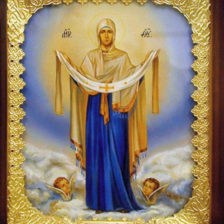

Изображение: <PIL.Image.Image image mode=RGB size=224x224 at 0x7CFD91948CD0>
Текст: средневековые университеты
Целевая метка: 2
---------------------------------------------------------------------------


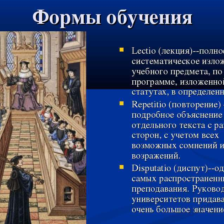

Изображение: <PIL.Image.Image image mode=RGB size=224x224 at 0x7CFD91AE40A0>
Текст: кухня низ угловой вверх прямой
Целевая метка: 2
---------------------------------------------------------------------------


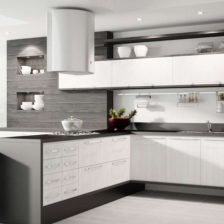

Изображение: <PIL.Image.Image image mode=RGB size=224x224 at 0x7CFD9264EE90>
Текст: шоколадные плитки открвтки
Целевая метка: 0
---------------------------------------------------------------------------


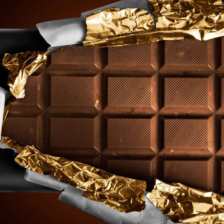

Изображение: <PIL.Image.Image image mode=RGB size=224x224 at 0x7CFD91D50D60>
Текст: yaponiya raqamli universiteti kirish ballari
Целевая метка: 0
---------------------------------------------------------------------------


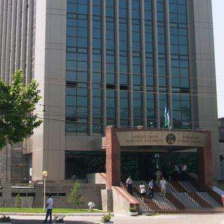

In [ ]:
dataset_info('Обучающая выборка', train_dataset)

In [ ]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

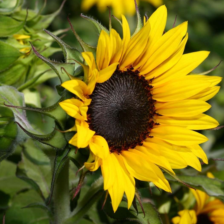

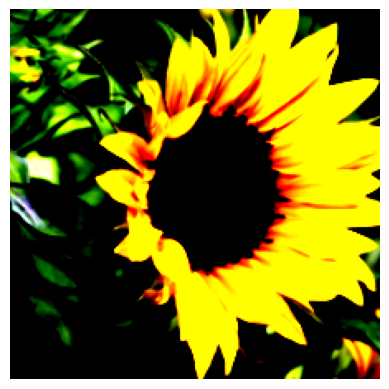

In [ ]:
img = train_dataset[10][0]
display(img)

image_tensor = preprocess(img)
image_tensor_np = image_tensor.permute(1, 2, 0).numpy()
plt.imshow(image_tensor_np)
plt.axis('off')
plt.show()

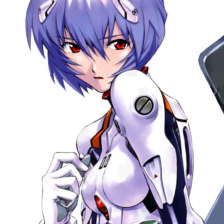

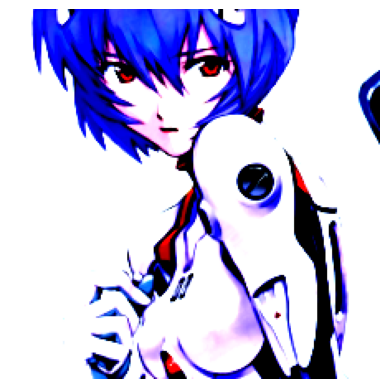

In [ ]:
img = val_dataset[3][0]
display(img)

image_tensor = preprocess(img)
image_tensor_np = image_tensor.permute(1, 2, 0).numpy()
plt.imshow(image_tensor_np)
plt.axis('off')
plt.show()

In [ ]:
ft_ru = FastText(language='ru')

.vector_cache/wiki.ru.vec:  90%|████████▉ | 4.45G/4.95G [00:44<00:05, 99.7MB/s]


KeyboardInterrupt: 

In [ ]:
#corpus = train_dataset.data['text']
#tfidf_vectorizer = TfidfVectorizer()
#tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
#print(tfidf_matrix.shape)

text = train_dataset[6][1]

# Токенизация текста
tokens = word_tokenize(text.lower())  # Приведение к нижнему регистру и токенизация
# Получение эмбеддингов слов и конкатенация
query_embeddings = [ft_ru[token] for token in tokens if token in ft_ru.stoi]
# Усреднение эмбеддингов слов для получения эмбеддинга запроса
if query_embeddings:
    avg_embedding = torch.mean(torch.stack(query_embeddings), dim=0)
    vectorized_query = avg_embedding
else:
    # Если запрос состоит только из неизвестных слов, можно использовать нулевой тензор или другой метод
    vectorized_query = torch.zeros(ft_ru.dim)

# Преобразование в тензоры PyTorch
vectorized_query.size()

In [ ]:
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad_(False)
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
resnet.eval()

img = train_dataset[7][0]
image_tensor = preprocess(img)
img_features = resnet(image_tensor.unsqueeze(0)).flatten()
img_features

In [ ]:
def img_emb_gen(dataset):
    img_emb = []
    for idx in range(len(dataset)):
      image = dataset[idx][0]
      image_tensor = preprocess(img)
      output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
      output_tensor.size()
      img_emb.append(output_tensor.numpy())
    img_emb_df = pd.DataFrame(img_emb, columns=[f'img_emb_{i}' for i in range(512)])
    dataset.data = pd.concat([dataset.data, img_emb_df], axis=1)

In [ ]:
img_emb_gen(train_dataset)
train_dataset.data.head()

NameError: name 'img_emb_gen' is not defined

In [ ]:
def txt_emb_gen(dataset):
  txt_emb = []
  # Токенизация текста
  tokens = word_tokenize(text.lower())  # Приведение к нижнему регистру и токенизация
  # Получение эмбеддингов слов и конкатенация
  query_embeddings = [ft_ru[token] for token in tokens if token in ft_ru.stoi]
  # Усреднение эмбеддингов слов для получения эмбеддинга запроса
  if query_embeddings:
      avg_embedding = torch.mean(torch.stack(query_embeddings), dim=0)
      vectorized_query = avg_embedding
  else:
      # Если запрос состоит только из неизвестных слов, можно использовать нулевой тензор или другой метод
      vectorized_query = torch.zeros(ft_ru.dim)

  text_features = vectorized_query

In [ ]:
class KombiNet(nn.Module):
    def __init__(self, num_classes):
        super(KombiNet, self).__init__()
        self.norm = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            self.norm,
        ])

        # ResNet для обработки изображений
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad_(False)
        modules = list(self.resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.resnet.eval()

        # FastText для векторизации слов
        self.ft_ru = FastText(language='ru')

        # Полносвязный слой для объединенных признаков
        self.fc_combined = nn.Linear(512 + 300, num_classes)

    def forward(self, img, text):
        # Проход изображения через ResNet
        image_tensor = self.preprocess(img)
        img_features = self.resnet(image_tensor.unsqueeze(0)).flatten()

        # Токенизация текста
        tokens = word_tokenize(text.lower())  # Приведение к нижнему регистру и токенизация
        # Получение эмбеддингов слов и конкатенация
        query_embeddings = [self.ft_ru[token] for token in tokens if token in self.ft_ru.stoi]
        # Усреднение эмбеддингов слов для получения эмбеддинга запроса
        if query_embeddings:
            avg_embedding = torch.mean(torch.stack(query_embeddings), dim=0)
            vectorized_query = avg_embedding
        else:
            # Если запрос состоит только из неизвестных слов, можно использовать нулевой тензор или другой метод
            vectorized_query = torch.zeros(self.ft_ru.dim)

        text_features = vectorized_query

        # Конкатенация признаков изображения и текста
        combined_features = torch.cat((img_features, text_features), dim=1)

        # Проход через полносвязный слой для объединенных признаков
        output = self.fc_combined(combined_features)
        return output


In [ ]:
def train(model, device, train_dataloader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  num_epochs = 10
  for epoch in range(num_epochs):
      model.train()  # Установка модели в режим обучения
      running_loss = 0.0
      for images, texts, labels in train_dataloader:  # Предполагается, что у вас есть DataLoader для вашего набора данных
          images = images.to(device)
          texts = texts.to(device)
          labels = labels.to(device)
          # Обнуление градиентов
          optimizer.zero_grad()
          # Прямой проход
          outputs = model(images, texts)
          # Рассчет потерь
          loss = criterion(outputs, labels)
          # Обратный проход и оптимизация
          loss.backward()
          optimizer.step()

          # Сохранение статистики
          running_loss += loss.item()

      # Вывод статистики о потерях на этапе обучения
      print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_dataloader)}")

  print('Обучение завершено')

In [ ]:
device = torch.device('cuda:0')
model = KombiNet(num_classes=3).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 91.7MB/s]


In [ ]:
train(model, device, train_dataloader)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [ ]:
def validate(model, dataloader, device):
    criterion = nn.CrossEntropyLoss()
    model.eval()  # Переключение модели в режим оценки
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Отключение вычисления градиентов во время оценки
        for images, texts, labels in dataloader:
            # Перенос данных на указанное устройство
            images = images.to(device)
            texts = texts.to(device)
            labels = labels.to(device)

            # Прямой проход
            outputs = model(images, texts)

            # Рассчет потерь
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Подсчет правильных предсказаний
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    # Рассчет средней потери и точности
    average_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    return average_loss, accuracy

In [ ]:
validate(model, val_dataloader, device)

In [ ]:
def evaluate_accuracy(model, data_loader):
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0
    total = 0
    with torch.no_grad():  # Отключаем вычисление градиентов
        for images, texts, labels in data_loader:
            images = images.to(device)
            texts = texts.to(device)
            labels = labels.to(device)
            outputs = model(images, texts)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
class TestDataset(Dataset):
    def __init__(self, zip_file, tsv_file, image_dir):
        self.image_dir = image_dir
        self.zip_file = zip_file
        self.data = pd.read_csv(tsv_file, sep='\t')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if os.path.exists(os.path.join(self.image_dir, self.data.iloc[idx, 0])):
          image = Image.open(os.path.join(self.image_dir, self.data.iloc[idx, 0]))
        else:
          image = zip2jpeg(self.zip_file, self.data.iloc[idx, 0], self.image_dir)
        text = self.data.iloc[idx, 1]
        return image, text

In [ ]:
test_dataset = TestDataset(test_images_zip, test_queries,
                              os.path.join(work_dir, 'test_images'))

test_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)

In [ ]:
def predict(model, device, dataloader):
    model.eval()  # Установка модели в режим оценки
    predictions = []
    with torch.no_grad():  # Отключение вычисления градиентов
        for images, texts in dataloader:
            # Перемещение данных на устройство и прямой проход через модель
            images = images.to(device)
            texts = texts.to(device)
            outputs = model(images, texts)
            # Применение softmax к выходам модели
            probabilities = F.softmax(outputs, dim=1)
            # Выбор индекса класса с наибольшей вероятностью
            _, predicted = torch.max(probabilities, 1)
            predictions.extend(predicted.cpu().numpy())  # Преобразование индексов к числовому типу и добавление в список
    return images, texts, predictions

# Использование функции predict
device = torch.device('cuda:0')  # Установка устройства (GPU)
test_predictions = predict(model, device, test_dataloader)  # Получение предсказаний для тестовой выборки